# Data Science for Good: City of Los Angeles
## Background;
When candidates are hunting for new jobs, the content, tone, and format of job bulletins can influence wether the candidates would apply or not. Therefore, improving the quality of the job description is essential for a better applicant pool.

The goal of this notebook is to demenstrate the process of conveting the plain text job description to a single structured CSV file. Afterwords, we would use this data to: 
1. Identify language that can negatively bias the pool of applicants; 
2. Improve the diversity and quality of the applicant pool; 
3. Make it easier to determine which promotions are available to employees in each job class.



## Data preparation

In [1]:
# Configuration and package installation
import pandas as pd
import numpy as np
import datetime as dt
import re
import csv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
!pip install textstat
import textstat
import nltk
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from collections  import Counter
!pip install find_job_titles
!pip install graphviz
from find_job_titles import FinderAcora
from graphviz import Digraph
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Prevent warning message, making report more user-friendly
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

     |████████████████████████████████| 389kB 2.8MB/s 
     |████████████████████████████████| 184kB 31.2MB/s 
     |████████████████████████████████| 133kB 2.8MB/s 


In [2]:
# Open files directory 
files=[dir for dir in os.walk('../input/cityofla/CityofLA')]

bulletins=os.listdir("../input/cityofla/CityofLA/Job Bulletins/")
additional=os.listdir("../input/cityofla/CityofLA/Additional data/")

In [3]:
# Create a list of job positions: each element of list is one job description
job = []

for bullet in bulletins:
    
    f = open("../input/cityofla/CityofLA/Job Bulletins/"+ bullet,encoding='latin-1')
    position = f.read()
    pos = position.replace('\t','').replace('\n','')
    f.close()
    
    job.append(pos)

In [4]:
# Write regular patterns of each feature
date = '(\d\d\d\d\d\d)'
code = '(\d\d\d\d)'
salary = '\$(\d+,\d+)(\s(to|and)\s)(\$\d+,\d+)'
require1 = '(REQUIREMENTS?/\s?MINIMUM QUALIFICATIONS?)(.*)(PROCESS NOTE)' 
require2 = '(REQUIREMENTS?)(.*)(NOTES?)'
educate = 'College or University|College|University|High School|college or university|college|university|high school|special degree program|degree program|undergraduate|Undergraduate|Graduate|graduate|Bachelor’s Degree|Bachelor|Master|Master’s Degree|Doctoral or Professional Degree'
experience = 'paid experience|volunteer experience|unpaid experience|full-time experience|part-time experience|full time experience|part time experience|work experience|experiences|experience'

# Check regular patterns function 
def check_re(pat, S):
    return bool(re.search(pat, S))

# Extract Title to a list
Title = []
for i in bulletins:
    Title.append(re.split("\d{4}", i)[0].lower())

Title = pd.Series(Title)

# Extract OpenDate to a list
OpenDate = []
for i in range(len(bulletins)):
    if check_re(date,bulletins[i]) == True:
        OpenDate.append(re.search(date,bulletins[i]).group())
    else:
        OpenDate.append('')
        
OpenDate = pd.Series(OpenDate)

# Extract ClassNode to a list
ClassCode = []
for i in range(len(job)):
    if check_re(code,job[i]) == True:
        ClassCode.append(re.search(code,job[i]).group())
    else:
        ClassCode.append('')
    
ClassCode = pd.Series(ClassCode)

# Extract Salary to a list
Salary = []
for i in range(len(job)):
    if check_re(salary,job[i]) == True:
        Salary.append(re.search(salary,job[i]).group())
    else:
        Salary.append('')

Salary = pd.Series(Salary)

SalaryStart = []
SalaryEnd = []
for i in range(len(Salary)):
    if Salary[i] != '':
        SalaryStart.append(re.split('(to|and)',Salary[i])[0])
        SalaryEnd.append(re.split('(to|and)',Salary[i])[2])
    else:
        SalaryStart.append('')
        SalaryEnd.append('')

SalaryStart = pd.Series(SalaryStart)
SalaryEnd = pd.Series(SalaryEnd)

# Check regular patterns function 
def check_re(pat, S):
    return bool(re.search(pat, S))

# Extract Requirement to a list
Requirement = []
for i in range(len(job)):
    if check_re(require1,job[i]) == True:
        Requirement.append(re.search(require1,job[i]).group(2))
    elif check_re(require2,job[i]) == True:
        try:
            Requirement.append(re.search('(.*)NOTES?',re.findall(r'(REQUIREMENTS?)(.*)(NOTES?)',job[i])[0][1][:1200]).group(0))
        except:
            Requirement.append('NA')
    else:
        Requirement.append('')

# Clean requirement:       
for r in range(len(Requirement)):
    if 'NOTE' in Requirement[r]:
        Requirement[r] = Requirement[r].split("NOTE",1)[0]    
        
Requirement = pd.Series(Requirement)

# Extract FileName to a list
FileName = pd.Series(bulletins)

# Extract Length to a list
Length = []
for i in range(len(job)):
    Length.append(len(job[i].split()))
    
Length = pd.Series(Length)

# Extract Education Level to a list
Education = []
for i in range(len(Requirement)):
    if check_re(educate,Requirement[i]) == True:
        Education.append(re.search(educate,Requirement[i]).group(0))
    else:
        Education.append('no education required')

for i in range(len(Education)):
    if check_re('College or University|College|University|college or university|college|university|undergraduate|Undergraduate|Bachelor’s Degree|Bachelor',Education[i]) == True:
        Education[i] = 'college or university'
    elif check_re('High School|high school',Education[i]) == True:
        Education[i] = 'high school'
    elif check_re('Graduate|graduate|Master|Master’s Degree|Doctoral or Professional Degree', Education[i]) == True:
        Education[i] = 'graduate'
    elif check_re('special degree program|degree program',Education[i]):
        Education[i] = 'special degree program'
    else:
        Education[i] = Education[i]


Education = pd.Series(Education)

# Extract Experience Level to a list
Experience = []
for i in range(len(Requirement)):
    if check_re(experience,Requirement[i]) == True:
        Experience.append('require experience')
    else:
        Experience.append('no experience required')
           
Experience = pd.Series(Experience)

In [5]:
# Extract Duties to a list
Duties = []
duty = '(DUTIES)(\s*)'

for bullet in bulletins:
    f = open("../input/cityofla/CityofLA/Job Bulletins/"+ bullet,encoding='latin-1')
    jobList = f.readlines()
    for i in range(len(jobList)):
        jobList[i] = jobList[i].replace('\n','')
    
    jobList = [elem for elem in jobList if elem != '']
          
    if sum(1 for i in range(len(jobList)) if check_re(duty,jobList[i]) == True) == 1:
        for i in range(len(jobList)):
            if check_re(duty,jobList[i]) == True:
                Duties.append(jobList[i+1])
    else:
        Duties.append('') # some job description doesn't contains duties

Duties = pd.Series(Duties)

# EXtract Deadlines of applications
EndDate = []
for i in job:
    try:
        EndDate.append(re.search(r'(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2},\s\d{4})',i).group())
    except Exception as e:
        EndDate.append(np.nan)
        
EndDate = pd.Series(EndDate)

In [6]:
# Create dataframe for further analysis
df = pd.concat([FileName, Title, OpenDate, ClassCode, Salary,SalaryStart, SalaryEnd, 
                Requirement, Experience, Education, Duties, Length,EndDate], axis=1)
df.columns = ['FileName','Title', 'OpenDate', 'ClassCode', 'Salary','SalaryStart', 'SalaryEnd', 
              'Requirement','Experience', 'Education', 'Duties','Length','EndDate']

In [7]:
# Correct the column types: SalaryStart and SalaryEnd
df['SalaryStart'] = df['SalaryStart'].str.replace('$','')
df['SalaryStart'] = df['SalaryStart'].str.replace(',','')
df['SalaryStart'] = pd.to_numeric(df['SalaryStart'])

df['SalaryEnd'] = df['SalaryEnd'].str.replace('$','')
df['SalaryEnd'] = df['SalaryEnd'].str.replace(',','')
df['SalaryEnd'] = pd.to_numeric(df['SalaryEnd'])

# Fill the missing values with mean
df['SalaryStart'] = df['SalaryStart'].fillna(df['SalaryStart'].mean())
df['SalaryEnd'] = df['SalaryEnd'].fillna(df['SalaryEnd'].mean())

# Delete unnecessary column
del df['Salary']

# Set class code as index
df = df.set_index('ClassCode')

In [8]:
# Assign the null value a new value: '010100'
for i in range(len(df['OpenDate'])):
    if df['OpenDate'][i] == '':
        df['OpenDate'][i] = '010100'

# Transform column type into datetime
df['OpenDate'] = df['OpenDate'].apply(lambda x : dt.datetime.strptime(x, '%m%d%y'))

In [9]:
df.head()

,FileName,Title,OpenDate,SalaryStart,SalaryEnd,Requirement,Experience,Education,Duties,Length,EndDate
ClassCode,,,,,,,,,,,
2454,ARTS ASSOCIATE 2454 072117 REV 072817.txt,arts associate,2017-07-21,48797.000000,71326.000000,1. A bachelor's degree from an accredited four...,require experience,college or university,An Arts Associate performs a broad range of en...,2178,"AUGUST 3, 2017"
3638,SENIOR COMMUNICATIONS ELECTRICIAN 3638 030317 ...,senior communications electrician,2017-03-03,79351.186275,106090.323529,Two years of full-time paid experience in a cl...,require experience,no education required,A Senior Communications Electrician acts as a ...,1198,"MARCH 16, 2017"
3716,SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,senior automotive supervisor,2015-11-20,103126.000000,111875.000000,Two years of full-time paid experience with th...,require experience,no education required,A Senior Automotive Supervisor assists in plan...,1040,"DECEMBER 3, 2015"
4110,WASTEWATER COLLECTION WORKER 4110 102612 REV 0...,wastewater collection worker,2012-10-26,43973.000000,62556.000000,1. One year of full-time paid experience with ...,require experience,no education required,A Wastewater Collection Worker performs a vari...,1341,NaN
1837,SENIOR STOREKEEPER 1837 052518.txt,senior storekeeper,2018-05-25,52806.000000,77172.000000,Two years of full-time paid experience as a St...,require experience,no education required,"A Senior Storekeeper assigns, reviews and eval...",1443,"JUNE 7, 2018"


## Data Analysis

### How does the length of words distributed?
#### Problem 1.1:
First, we want to know the number of words in each job description. Length of job description could reflect the efficiency of job description in some degree. We use histogram to visualize the distribution of the number of words in job descriptions. The x-axis is the bins of number of words and the y-axis is the frequency.

In [10]:
# Describe the statistics of length of words
df['Length'].describe()

count     683.000000
mean     1532.370425
std       365.961020
min       723.000000
25%      1273.000000
50%      1483.000000
75%      1747.000000
max      3070.000000
Name: Length, dtype: float64

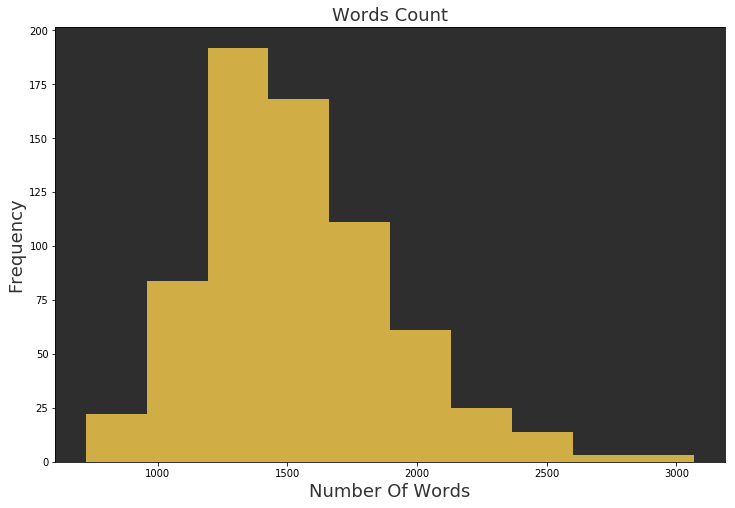

In [11]:
# Plot histogram 
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df['Length'], bins=10, color="#d1ae45")

# Set title label legend and xtickers
plt.title('Words Count',size = 18,alpha=0.8)
plt.xlabel('Number Of Words',size = 18,alpha=0.8)
plt.ylabel('Frequency',size = 18,alpha=0.8)


# Change background color inside the axes
ax.set_facecolor("#2E2E2E")

plt.show();

#### Findings:
From the plot, it can be find that the distribution is a right-skewed distribution. Most of job posts contain less than 2000 but greater than 1000 words. Only a few of job descriptions contain more than 2000 words. Based on the research of Indeed.com, it shows that 'job descriptions between 700 and 2,000 characters get up to 30% more applications', which indicates that it would be better to write more concise job description than a tedious one. 

#### Recommendation:
We recommend that recruiters should pay attention to the length of job posting and make efforts to limit the length of job post within 1000 words. The job post is also a type of reflection of company culture and work attitude. Efficiency would attract more applicants. Recruiters should find a good balance between providing enough details so that the candidates could fully understand the requirements and duties while keeping the description concise. 

#### Reference:
https://www.indeed.com/hire/how-to-write-a-job-description?matchtype=b&network=g&device=c&devicemodel=&creative=355143870850&keyword=%2Bjob%20%2Bdescriptions&placement=&param1=&param2=&random=3857810173098333339&aceid=&adposition=1t1&utm_source=google&utm_medium=cpc&utm_term=job+descriptions&utm_campaign=job+description+pages+general+0+%28bmm%29&utm_medium=cpc&utm_source=google_search&utm_campaign=2001311670&utm_term=kwd-17476351936&gclid=EAIaIQobChMIlPaS7u_64gIVT-DICh1eIAqJEAAYASAAEgL6XPD_BwE

#### Problem 1.2:
Also, we want to know the length of job title, job requirements and job duties separately. We use three boxplots to visualize data. The x-axis is the number of counts.

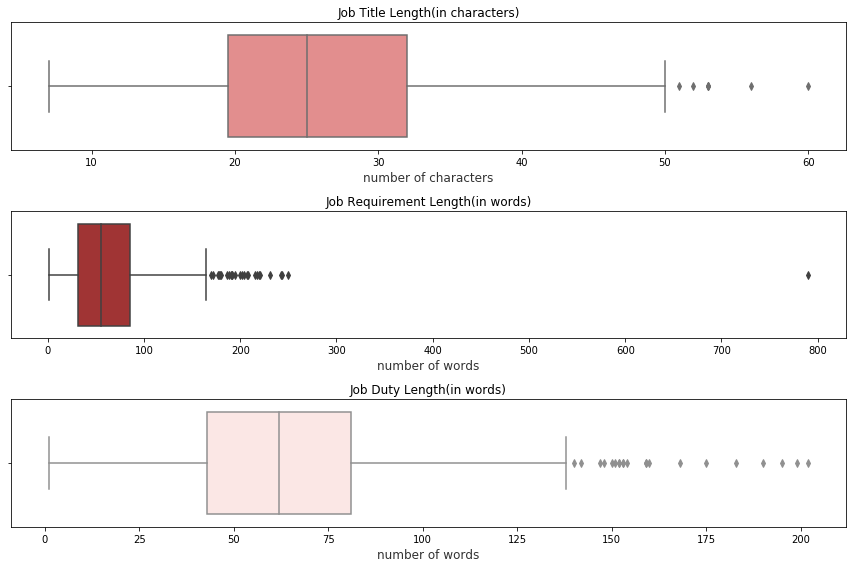

In [12]:
# Count the number of characters in Title and number of words in Requirements and Duties
df['TitleLen'] = df['Title'].apply(lambda x: len(x))
df['RequireLen'] = df['Requirement'].apply(lambda x: len(x.split(' ')))
df['DutiesLen'] = df['Duties'].apply(lambda x: len(x.split(' ')))

fig = plt.figure(2,(12,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Subplot the length of job title
fig.add_subplot(3,1,1)
sns.boxplot(x=df['TitleLen'],color = 'lightcoral')
plt.title('Job Title Length(in characters)')
plt.xlabel('number of characters',size = 12,alpha=0.8)

# Subplot the length of job requirements
fig.add_subplot(3,1,2)
sns.boxplot(x=df['RequireLen'],color = 'firebrick')
plt.title('Job Requirement Length(in words)')
plt.xlabel('number of words',size = 12,alpha=0.8)

# Subplot the length of job duties
fig.add_subplot(3,1,3)
sns.boxplot(x=df['DutiesLen'],color = 'mistyrose')
plt.title('Job Duty Length(in words)')
plt.xlabel('number of words',size = 12,alpha=0.8)


plt.tight_layout()
plt.show()

#### Findings:
From the plots, it can be seen that most job titles are within 20 to 35 characters, most job requirements are less than 100 words, and most job duties are within 40 to 80 words. Most job posts have a reasonable number of words, which is good for applicants to read. It indicates that the core components of job posting (requirement and duty) are very concise for most job posts.

#### Recommendation:
Our recommendation is that it would be better to simplify the words about the description of hiring processes and additional information of the job position. If the content of additional information are much more than the core information of job description, it would divert applicats attention from the more important information. 

### What are the basic salary distributed of different kinds of common experience requirement?
#### Problem 2:
Then, we want to know the general distribution of starting salary. We use distribution plot to visualize data. The x-axis is the starting salary and the y-axis is the probability.

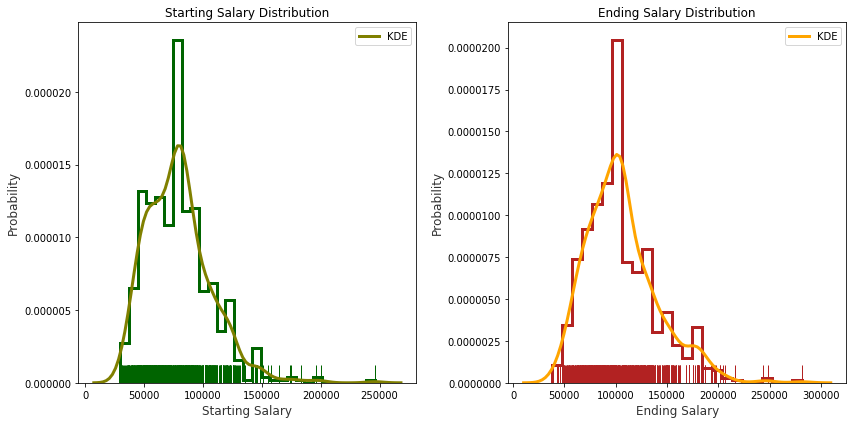

In [13]:
# Plot starting salary distplot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['SalaryStart'], rug=True, rug_kws={"color": "darkgreen"},
             kde_kws={"color": "olive", "lw": 3, "label": "KDE"},
             hist_kws={"histtype": "step", "linewidth": 3,
                       "alpha": 1, "color": "darkgreen"})

plt.title('Starting Salary Distribution')
plt.ylabel('Probability',size = 12,alpha=0.8)
plt.xlabel('Starting Salary',size = 12,alpha=0.8)

# Plot ending salary distplot
plt.subplot(1,2,2)
sns.distplot(df['SalaryEnd'], rug=True, rug_kws={"color": "firebrick"},
             kde_kws={"color": "orange", "lw": 3, "label": "KDE"},
             hist_kws={"histtype": "step", "linewidth": 3,
                       "alpha": 1, "color": "firebrick"})
plt.title('Ending Salary Distribution')
plt.ylabel('Probability',size = 12,alpha=0.8)
plt.xlabel('Ending Salary',size = 12,alpha=0.8)

plt.tight_layout()

plt.show()

#### Findings 2.1:
From the plots, it can be seen that the starting salary and ending salary basically conform to normal distribution. Most starting salary falls between 50000 and 100000, while most ending salary falls between 75000 and 12500. In terms of ZipRecruiter.com, it says that 'A pay range will generally spread +/- 15-20% from the midpoint, but any range the employer feels is appropriate is acceptable, and ranges may be different for different grades.' Most of the job description conform to this rule. However, a few of job description has a huger range of salary. As shown in the following tables.

#### Reference:
https://www.ziprecruiter.com/blog/how-to-set-a-salary-and-create-pay-grades/

In [14]:
# Calculating the difference of salary start and salary end 
df['SalaryDiff']=abs(df['SalaryEnd']-df['SalaryStart'])

# Filter the top 10 job position with largest difference of salary
ranges=df[['Title','SalaryDiff']].sort_values(by='SalaryDiff',ascending=False)[:10]
ranges

,Title,SalaryDiff
ClassCode,,
3129,construction and maintenance superintendent,75293.0
9302,director of airports administration,60009.0
9304,director of airport operations,60009.0
9143,portfolio manager,59112.0
1404,airport chief information security officer,58025.0
7625,director of communications services,56877.0
9180,chief of parking enforcement operations,56877.0
1768,director of airport marketing,56877.0
9489,principal civil engineer,56877.0


#### Findings 2.2:
From the table, it can be seen that manager, director, principal, superintendent usually has the largest gap in starting salary and ending salary. It indicates that the salary of hign-rank position has more upside potential. There are more space for applicants to negotiate salary. 


#### Recommendation:
Our recommendation is that recruiters should clearly label the lowest salary and the highest salary of one job position. In order to avoid any confusion, the salary range should be within 15% to 20% from the mean of salary. Also, recruiters could also establish some pay grades or highlight pay equity in job description. For example, entry-level may be paid 75-80% of the market rate and high-experienced employees would max out around 120-125% of the market rate.

### How does the education or experience be mentioned in job description?
#### Problem 3: 
Next, we want to know whether there are education requirements in job description. We use a donut chart (pie chart) to visualize the eduaction data and use bar chart to visualize experience data.

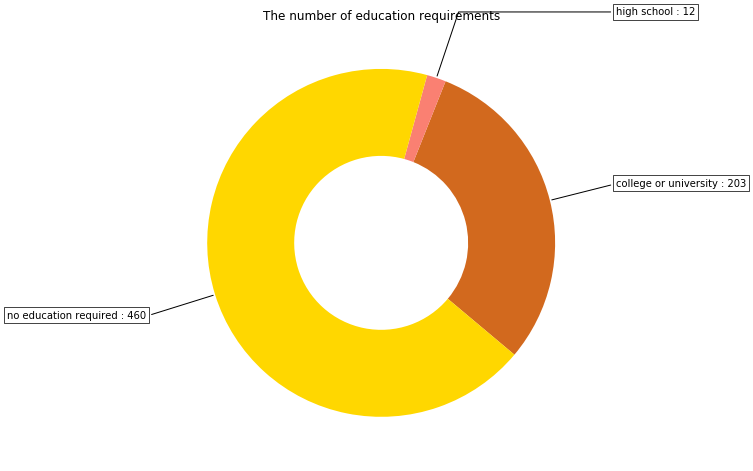

In [15]:
# Count the occurance of education requirements 
education = pd.DataFrame(df.groupby(by='Education').agg({'Title': 'count'}))
education.columns = ['count']
education = education[education['count'] > 10]
education.sort_values(by = 'count',ascending=False)


# Create donut plot to visualize the occurance of education requirements 
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(education['count'], wedgeprops=dict(width=0.5), startangle=-40,colors=['chocolate','salmon','gold'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

# Demonstrate the value of each category instead of percentage as the default value
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(str(education.index[i])+' : '+str(education['count'][i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("The number of education requirements")

plt.show()

#### Findings 3.1:
From the plot, it can be seen more than half of the job description don't have a educational background bias and don't mention the required degree. about one third job posts require college or university degree. Based on the research of Harvard Business School, employers should stop requiring college degree for middle-skill jobs because it may cause "degree inflation". 

#### Recommendation 3.1:
Our recommendation is that for high-level jobs, it would be better to explicit the minimum requirement of education degree. However, for low-level jobs or medium-level jobs, it is better not to include any requirements of education degree. We think that most of the recruiters did well in this point. It is because the emphasis of the education may cause degree inflation so that applicants may regard the company with bias. It's better to not let a college degree become a barrier to entering the workforce or seeking their careers. Instead, sometimes experience in related fields may be more important.

#### Reference:
https://hbswk.hbs.edu/item/why-employers-must-stop-requiring-college-degrees-for-middle-skill-jobs

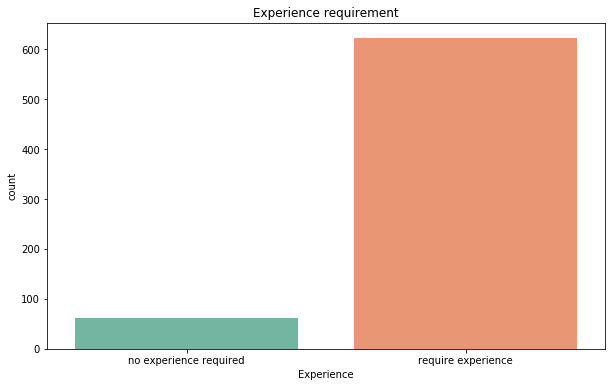

In [16]:
# Count the occurance of experience requirements 
experience = pd.DataFrame(df.groupby(by='Experience').agg({'Title': 'count'}))
experience.columns = ['count']
experience.sort_values(by = 'count',ascending=False)

# Plot the frequency of experience requirements
plt.figure(figsize=(10, 6))
sns.barplot(y=experience['count'],x=experience.index,palette="Set2")
plt.title('Experience requirement')

plt.show()

> #### Findings 3.2:
From the plot, most of the job posts list experience as one of the requirement. There are more than 600 job descriptions mention experience in job requirements. We think this is good because relavant work experience would be very important to determine whether a candidates fit that job.

### How does the open date distributed? (in year/ month/ week/ season)
#### Problem 4:
Then, we want to explore how does the open date distribution in terms of year, quarter, month and week. We use four subplots to visualize data. The y-axis is the frequency of occurance.

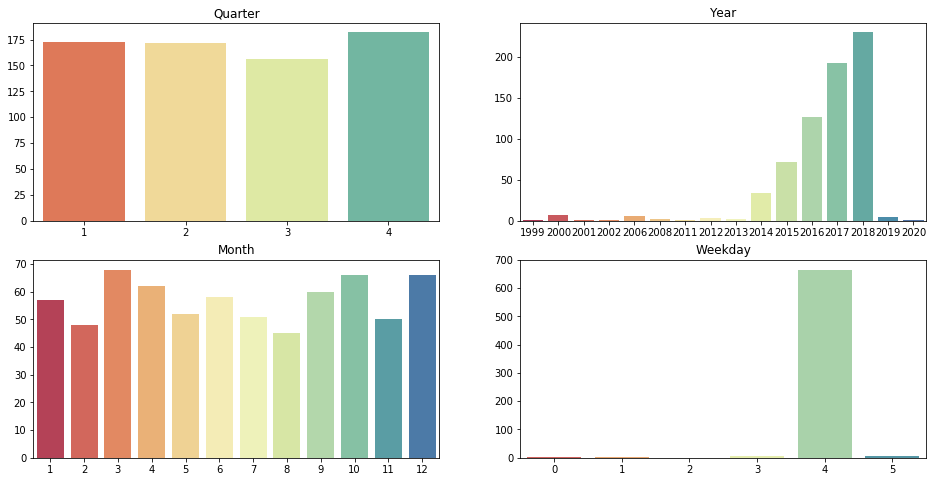

In [17]:
# Subplot quarter 
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
df['OpenQuarter']=[z.quarter for z in df['OpenDate']]
count=df['OpenQuarter'].value_counts(sort=False)
sns.barplot(y=count.values,x=count.index,palette='Spectral')
plt.title('Quarter')

# Subplot year
plt.subplot(2,2,2)
df['OpenYear']=[z.year for z in df['OpenDate']]
count=df['OpenYear'].value_counts(sort=False)
sns.barplot(y=count.values,x=count.index,palette='Spectral')
plt.title('Year')

# Subplot month
plt.subplot(2,2,3)
df['OpenMonth']=[z.month for z in df['OpenDate']]
count=df['OpenMonth'].value_counts(sort=False)
sns.barplot(y=count.values,x=count.index,palette='Spectral')
plt.title('Month')

# Subplot weekday
plt.subplot(2,2,4)
df['OpenDay']=[z.weekday() for z in df['OpenDate']]
count=df['OpenDay'].value_counts(sort=False)
sns.barplot(y=count.values,x=count.index,palette='Spectral')
plt.title('Weekday')


plt.show()

#### Findings:
From the plots, it can be seen that jobs are posted evenly in each quarter. March, October and December have the most job posts. The number of job posting has increased dramatically since 2014. However, the most interesting finding is that most job postings are released on Friday. That could be one problem for recruiters because Friday may not be the best day to release a job post. Based on the research of LinkedIn.com, it shows that there are the most applicants browse job website on Monday and fewest applicants on Friday and weekends. 

#### Recommendation:
Our recommendation is that recruiters could change the open day from Friday to Monday to increase the number of potential applicants. The more applicants, the more choices for one company. 

#### Reference:
https://business.linkedin.com/talent-solutions/blog/trends-and-research/2016/the-best-times-to-post-a-job-on-linkedin

### Readability Analysis
When we went through a few job post examples, we find that it's hard to understand the context of the file quickly. This is a problem when it comes to attracting more diverse and qualified candidates. Therefore, we performed a readability analysis on the job posts.

We decided to use *textstat* which is a Python package to calculate statistics from text to determine readability, complexity and grade level of a particular corpus. In addition, we use *Readability Consensus based upon all the above tests* which is based upon all the above tests, returns the estimated school grade level required to understand the text.

In [18]:
# Get the redability score of requirement for each job post
readability_score = []
for i in range(len(df)):
    temp = df['Requirement'][i]
    readability_score.append(textstat.text_standard(temp)[:2])
readability_score = pd.Series(readability_score).str.replace('[t]', '')

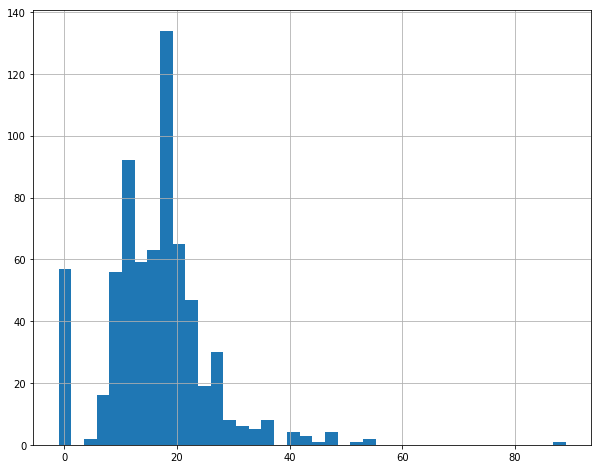

In [19]:
# Visualize the readability_score
readability_score = pd.to_numeric(readability_score)
readability_score.hist(bins=40, figsize = (10,8));

We find that the readability score distribution is not as good as we expected, around half are higher than 10. Not many candidates have that high level of education. Therefore, we recommmend that city of LA could consider to use simpler words and sentences to propose the job description which is easier to read.

### Gender bias in job posting
While the Civil Rights Act of 1964 prohibits employers from overtly soliciting a preferred gender in their job listings, research shows that the language of job descriptions often subtly adheres to gender stereotypes. And that deters members of the opposite gender from applying to those jobs.

Therefore, here we would like to perform text analysis in requirement, duties and title of job posting to find out wether gender bias is a problem of City of LA.

In [20]:
req=' '.join(text for text in df['Requirement'])
duties= ' '.join(d for d in df['Duties'])

In [21]:
def pronoun(data):
    
    '''function to tokenize data and perform pos_tagging.Returns tokens having "PRP" tag'''
    
    prn=[]
    vrb=[]
    token=word_tokenize(data)
    pos=pos_tag(token)
   
    vrb=Counter([x[0] for x in pos if x[1]=='PRP'])
    
    return vrb
    


req_prn=pronoun(req)
duties_prn=pronoun(duties)
print('pronouns used in requirement section are')
print(req_prn.keys())
print('\npronouns used in duties section are')
print(duties_prn.keys())

pronouns used in requirement section are
dict_keys(['or3', 'or2', 'you', 'I', 'orb', 'orc', 'or4', 'or5', 'or6', 'they', 'You', 'it', 'or7', 'or8', 'ore.', 'offset', 'orB'])

pronouns used in duties section are
dict_keys(['it', 'I', 'they', 's'])


As we can see from the result, we do not detect any gender bias words in the retuirement and duties section of all job postings. Therefore, we do encourge City of LA to continue to perform well on keeping the word neutral, imporving the diversity and the applicants pool.

### Find out whether the job post is negtive or positive¶
If the job post is more negtive, it not good for the candidates to read.

In [22]:
analyzer = SentimentIntensityAnalyzer()

# Write the function get_sentiment to get the sentiment information
def get_sentiment(column_name):
    sentiment = []
    for i in range(len(df)):
        temp = list(analyzer.polarity_scores(df[column_name][i]).values())[3]
        sentiment.append(temp)
        
    #print(sentiment)
    return sentiment

#### Sentiment Analysis for Responsibility
- score -1 ~ -0.25 means the text is negtive;
- score -0.25 ~ 0.25 means the text is neutral;
- score 0.25 ~ 1 means the text is positive.

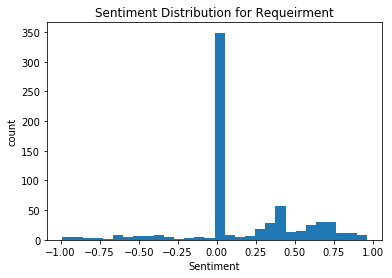

In [23]:
# Visualize the analysis for responsibility
plt.hist(get_sentiment('Requirement'), bins=30)
plt.title('Sentiment Distribution for Requeirment')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()

#### Sentiment Analysis for Duties

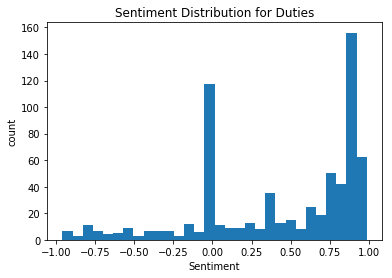

In [24]:
# Visualize the analysis for Duties
plt.hist(get_sentiment('Duties'), bins=30)
plt.title('Sentiment Distribution for Duties')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()

#### Sentiment Analysis for Title

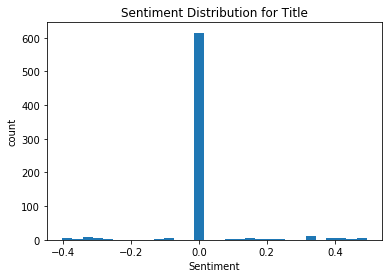

In [25]:
# Visualize the analysis for Title
plt.hist(get_sentiment('Title'), bins=30)
plt.title('Sentiment Distribution for Title')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()

The result of sentiment analysis shows that the text in requirement, duties, and titles are very neutral. Therefore, city of LA could continue to use the neutral words when propose a job post

### Promotion path
Since there are too many position in the promotion path and it's not easy to visualize, we decided to use *animal* related position to show the promotion path

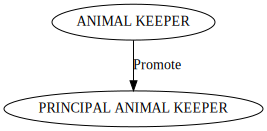

In [26]:
dot = Digraph(comment='Promotions')

finder=FinderAcora()
strReq = "Requirement"
arrRelation=[]
arrFinal=[]

def get_promotion(row):
    strLine = str(row [strReq]) #only check Requirement/minimum qualification section to get the promotion path
    # usually the promotion sentences start with "as a" and finish with "with"
    if strLine.find("as a") > 0:
        objItem = dict() 
        # only one previous position required
        #if strLine.find("or") < 0:
        strTemp = strLine[strLine.find("as a"):strLine.find("with")-1]
        strTemp = strTemp.replace("as an", "as a").replace("as a ","")
        if strTemp != "":
            for m in finder.findall(strTemp):
                objItem['Job1'] = row["Title"].lstrip().rstrip().upper()
                objItem['Job2'] = m[2].lstrip().rstrip().upper()
                arrRelation.append(objItem)
    return row
    
df = df.apply(get_promotion, axis=1)

pro = pd.DataFrame(arrRelation)
#pro.head()
#pro.to_csv('C:/Work/Promotion.csv')
pro = pro.drop_duplicates()
#Job1 is higher role and Job1 is the role which could promote to Job1
for index, row in pro.iterrows():
# as the image is too large, here just take police related jobs as an example
    if row["Job2"].startswith("ANIMAL"):
        dot.edge(row["Job2"], row["Job1"], label='Promote')
dot

In [27]:
# Extract data frame into csv file
df.to_csv('./jobs.csv', index=None)